# UniPd iCaRL

In [1]:
%load_ext autoreload
%autoreload 2

First of all let's append the parent and ```src``` directories so that we can easily import and use all the scripts created.

In [2]:
import sys
sys.path.append('..')
sys.path.append('../src')

We can now call the ```main()``` function from the ```main_incremental.py``` script. To pass the desired arguments to the function we use a list of arguments and values. In this incremental learning scenario, 2 classes are initially learned and the subsequent are learned one by one. We use 20 exemplars per class and 5 epochs.

In [3]:
from src.main_incremental import main

argv = ['--approach', 'icarl', '--datasets', 'unipd', '--network', 'XaviNet', 
        '--num-exemplars-per-class', '20', '--batch-size', '32', '--nepochs', 
        '5', '--lr', '1e-3', '--nc-first-task', '2', '--num-tasks', '10', 
        '--exemplar-selection', 'herding', '--log', 'tensorboard']

acc_taw, acc_tag, forg_taw, forg_tag, logger_path, appr = main(argv)

Arguments =
	approach: icarl
	batch_size: 32
	clipping: 10000
	datasets: ['unipd']
	eval_on_train: False
	exp_name: None
	f: 
	fix_bn: False
	gpu: 0
	gridsearch_tasks: -1
	keep_existing_head: False
	last_layer_analysis: False
	log: ['tensorboard']
	lr: 0.001
	lr_factor: 3
	lr_min: 0.0001
	lr_patience: 5
	momentum: 0.0
	multi_softmax: False
	nc_first_task: 2
	nepochs: 5
	network: XaviNet
	no_cudnn_deterministic: False
	num_tasks: 10
	num_workers: 4
	pin_memory: False
	pretrained: False
	results_path: /home/xcucurull/Documents/FACIL/results
	save_models: False
	seed: 0
	stop_at_task: 0
	use_valid_only: False
	warmup_lr_factor: 1.0
	warmup_nepochs: 0
	weight_decay: 0.0
Approach arguments =
	lamb: 1
Exemplars dataset arguments =
	exemplar_selection: herding
	num_exemplars: 0
	num_exemplars_per_class: 20
[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
************************************************************************************************************

/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Now that the training has been done for the whole "task" we can use the resulting ```approach``` object to classify unseen data.

### Test on custom data

In [4]:
# Load data
import os
import numpy as np

custom_data_path = os.path.join('..', 'data', 'xavi_data')

# TODO recreate new_data.npy
x = np.load(os.path.join(custom_data_path, 'new_data_x.npy'), allow_pickle=True)
y = np.load(os.path.join(custom_data_path, 'new_data_y.npy'), allow_pickle=True)

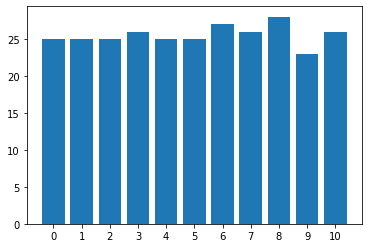

In [5]:
# Class distribution
%matplotlib inline
import matplotlib.pyplot as plt

classes, count = np.unique(y, return_counts=True)

plt.bar(classes, count)
plt.xticks(classes)
plt.show()

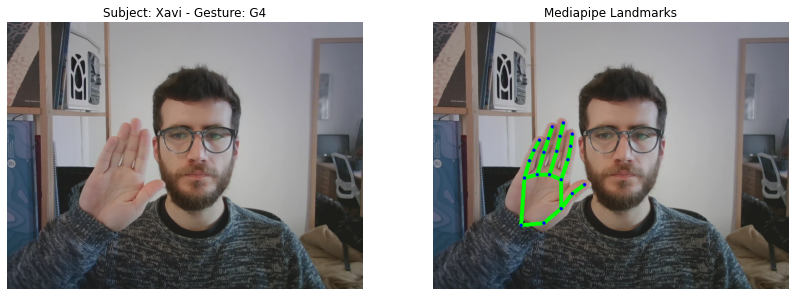

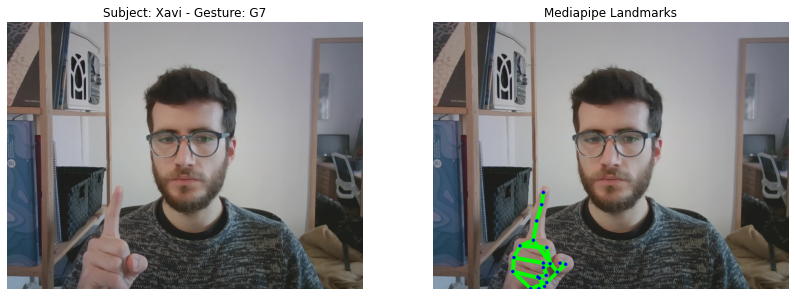

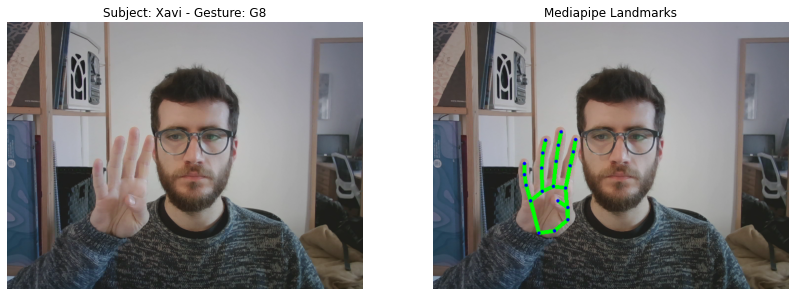

In [6]:
# Plot example
import cv2
import utils_landmarks

def plot_image_landmarks(image_path, landmarks, subject, gesture):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 10))
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Subject: {subject} - Gesture: {gesture}')    
    plt.subplot(122)
    plt.title('Mediapipe Landmarks')  
    image = utils_landmarks.draw_landmarks(image, landmarks)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    

gesture = 'G4'
landmarks = x[10]
image_path = os.path.join(custom_data_path, '3_010.png')
plot_image_landmarks(image_path, landmarks, 'Xavi', gesture)

gesture = 'G7'
landmarks = x[158]
image_path = os.path.join(custom_data_path, '6_002.png')
plot_image_landmarks(image_path, landmarks, 'Xavi', gesture)

gesture = 'G8'
landmarks = x[26]
image_path = os.path.join(custom_data_path, '7_000.png')
plot_image_landmarks(image_path, landmarks, 'Xavi', gesture)

In [7]:
# Calculate feature vector (Distances)
def calc_dist_feature(landmark_list):
    landmark_num = len(landmark_list)//2
    landmark_dist_features = []
    for i in range(landmark_num):
        for j in range(landmark_num):
            if j>i:
                landmark_dist_features.append(landmark_list[2*i] - landmark_list[2*j])      # x
                landmark_dist_features.append(landmark_list[2*i+1] - landmark_list[2*j+1])  # y

    data_tensor = np.array(landmark_dist_features, dtype=np.float32)
    
    return data_tensor

x_feature = [calc_dist_feature(l) for l in x]

In [8]:
# Create dataset and dataloader from arrays
# https://stackoverflow.com/a/44475689
import torch
from torch.utils.data import TensorDataset, DataLoader

tensor_y = torch.Tensor(y).to(torch.int64)
tensor_x = torch.Tensor(x_feature)    # transform to torch tensor

my_dataset = TensorDataset(tensor_x, tensor_y)    # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=32)    # create your dataloader

/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


In [9]:
help(appr.eval)

Help on method eval in module approach.icarl:

eval(t, val_loader, return_preds=False) method of approach.icarl.Appr instance
    Contains the evaluation code



In [20]:
# Make predictions and calculate accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

_, _, _, y_true, y_pred = appr.eval(9, my_dataloader, True)    # evaluate at last task (9)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       0.50      1.00      0.67        26
           4       1.00      0.68      0.81        25
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        27
           7       0.00      0.00      0.00        26
           8       1.00      1.00      1.00        28
           9       0.74      1.00      0.85        23
          10       1.00      1.00      1.00        26

    accuracy                           0.88       281
   macro avg       0.84      0.88      0.85       281
weighted avg       0.84      0.88      0.85       281



/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xcucurull/.pyenv/versions/iri/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

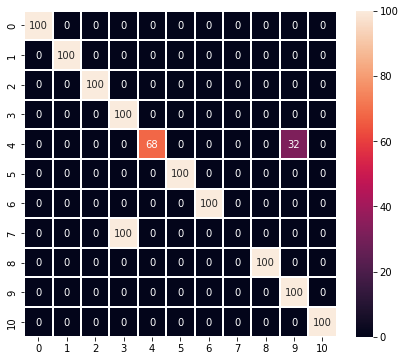

In [17]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(list(set(y_true)))
cmx_data = confusion_matrix(y_true, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(cmx_data.dot(100), annot=True, fmt='.0f' ,square=False, linewidths=.3, xticklabels=labels, yticklabels=labels)
plt.show()